# Dynamic linear models

In [3]:
import numpy as np
from numpy import linalg as la
from tabulate import tabulate 
import pandas as pd 
import LinearDynamic_ante as lm
from scipy.stats import chi2
import seaborn as sns
sns.set_theme();

np.set_printoptions(precision=5)
%load_ext autoreload
%autoreload 2

# Prepare the data

In this problem set, we consider the question of state dependence in **firm revenue** ($y$). The data, `cvr_extract.csv`, comes from the Danish register of firms, "CVR registret". It can be reconstructed or modified by downloading the tax files from [skst.dk](https://www.sktst.dk/aktuelt/skatteoplysninger-for-selskaber/) and running the notebook `clean_data.ipynb`. The accompanying notebook, `analysis.ipynb`, does some overly simplistic analyzing that illustrates some questions one might want to explore with the data. 

**Research question:** Should we provide assistance to firms? If the effects of adverse shocks (such as a pandemic) are very persistent, then we want to provide a safety net for firms. Conversely, if firms just rebound after a shock, that can be a waste of tax funds. 

The data consists of all firms observed in every year from 2012-2019, which satisfy that the net income (pre-tax) was below 10 mio. DKK. The variables in the data are: 

  |*Variable*  | *Content* |
  |------------| --------------------------------------------|
  |`net_inc`          | Net income (`income - deficit`) |
  |`taxable_income`          | Income |
  |`deficit`          | Losses |
  |`tax`          | Tax payment |
 | `cat`         | A categorical variable, based on the dummies, `dum_X` below |
  | `dum_X`          | Dummy for whether the firm's name contains the string `X` (in Danish) |
  
  The dummies, e.g. `dum_doctor`, are explained below 

| **Substring** | **If name contains** | 
| ---- | ------ | 
| `as` | 'a/s' | 
| `aps` | 'aps' | 
| `ivs` | 'ivs' | 
| `ab` | 'a/b' | 
| `realestate` | 'ejendom' | 
| `holding` | 'holding' | 
| `invest` | 'invest' | 
| `consult` | 'consult' | 
| `service` | 'service' | 
| `dot_dk` | '.dk' | 
| `doctor` | 'læge' | 
| `carpenter` | 'tømrer' | 
| `transport` | 'transport' or 'lastvogn' | 
| `plumbing` | 'vvs' or 'kloak' | 
| `import` | 'import' | 
| `masonry` | 'murer' | 
| `nielsen` | 'nielsen' | 
| `sorensen` | 'sørensen' | 

In [4]:
dat = pd.read_csv('cvr_extract.csv')
dat.sample(3)

,firmid,year,taxable_income,deficit,tax,net_inc,cat,dum_as,dum_aps,dum_ivs,...,dum_dot_dk,dum_doctor,dum_carpenter,dum_transport,dum_plumbing,dum_import,dum_masonry,dum_nielsen,dum_sorensen,dum_cars
28483,3560,2015,0.0,0.0,0.0,0.0,holding,0,0,0,...,0,0,0,0,0,0,0,0,0,0
472213,59026,2017,614.0,NaN,132.0,614.0,NaN,0,1,0,...,0,0,0,0,0,0,0,0,0,0
27139,3392,2015,96818.0,NaN,22748.0,96818.0,NaN,0,1,0,...,0,0,0,0,0,0,0,0,0,0


If you'd like a quick summary of your data, panda data frames have useful summary commands

In [5]:
dat.info() # returns number of elements, data type and column name for each column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519416 entries, 0 to 519415
Data columns (total 26 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   firmid          519416 non-null  int64  
 1   year            519416 non-null  int64  
 2   taxable_income  519416 non-null  float64
 3   deficit         325538 non-null  float64
 4   tax             519415 non-null  float64
 5   net_inc         519416 non-null  float64
 6   cat             206143 non-null  object 
 7   dum_as          519416 non-null  int64  
 8   dum_aps         519416 non-null  int64  
 9   dum_ivs         519416 non-null  int64  
 10  dum_ab          519416 non-null  int64  
 11  dum_realestate  519416 non-null  int64  
 12  dum_holding     519416 non-null  int64  
 13  dum_invest      519416 non-null  int64  
 14  dum_consult     519416 non-null  int64  
 15  dum_service     519416 non-null  int64  
 16  dum_dot_dk      519416 non-null  int64  
 17  dum_doctor

In [6]:
dat.describe() # returns a number of summary stats (e.g. mean, max, count etc.) for each column

,firmid,year,taxable_income,deficit,tax,net_inc,dum_as,dum_aps,dum_ivs,dum_ab,...,dum_dot_dk,dum_doctor,dum_carpenter,dum_transport,dum_plumbing,dum_import,dum_masonry,dum_nielsen,dum_sorensen,dum_cars
count,519416.000000,519416.00000,5.194160e+05,3.255380e+05,5.194150e+05,5.194160e+05,519416.000000,519416.000000,519416.000000,519416.000000,...,519416.000000,519416.000000,519416.000000,519416.000000,519416.000000,519416.000000,519416.000000,519416.000000,519416.0,519416.000000
mean,32463.000000,2015.50000,1.173396e+05,8.627641e+04,4.220691e+04,6.326685e+04,0.078317,0.768650,0.000204,0.017323,...,0.011488,0.016359,0.006767,0.004133,0.004334,0.001128,0.005027,0.010019,0.0,0.003654
std,18742.828504,2.29129,7.331761e+05,3.671005e+05,1.443852e+05,7.655319e+05,0.268670,0.421696,0.014284,0.130473,...,0.106564,0.126851,0.081984,0.064159,0.065688,0.033570,0.070722,0.099592,0.0,0.060339
min,0.000000,2012.00000,-9.922979e+06,0.000000e+00,-4.631800e+04,-9.922979e+06,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,16231.000000,2013.75000,-1.182900e+04,0.000000e+00,0.000000e+00,-5.625000e+04,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,32463.000000,2015.50000,0.000000e+00,0.000000e+00,0.000000e+00,-4.800000e+03,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
75%,48695.000000,2017.25000,7.752375e+04,3.384375e+04,1.751200e+04,5.950975e+04,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
max,64926.000000,2019.00000,1.483331e+07,1.714743e+07,3.187492e+06,9.987792e+06,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000


In [7]:
# print table which can be copied to latex
print(dat.describe().style.to_latex())

\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrr}
 & firmid & year & taxable_income & deficit & tax & net_inc & dum_as & dum_aps & dum_ivs & dum_ab & dum_realestate & dum_holding & dum_invest & dum_consult & dum_service & dum_dot_dk & dum_doctor & dum_carpenter & dum_transport & dum_plumbing & dum_import & dum_masonry & dum_nielsen & dum_sorensen & dum_cars \\
count & 519416.000000 & 519416.000000 & 519416.000000 & 325538.000000 & 519415.000000 & 519416.000000 & 519416.000000 & 519416.000000 & 519416.000000 & 519416.000000 & 519416.000000 & 519416.000000 & 519416.000000 & 519416.000000 & 519416.000000 & 519416.000000 & 519416.000000 & 519416.000000 & 519416.000000 & 519416.000000 & 519416.000000 & 519416.000000 & 519416.000000 & 519416.000000 & 519416.000000 \\
mean & 32463.000000 & 2015.500000 & 117339.591897 & 86276.405873 & 42206.912925 & 63266.847479 & 0.078317 & 0.768650 & 0.000204 & 0.017323 & 0.028696 & 0.230615 & 0.062545 & 0.015009 & 0.014226 & 0.011488 & 0.016359 & 0.006767 & 0.004

# Descriptives

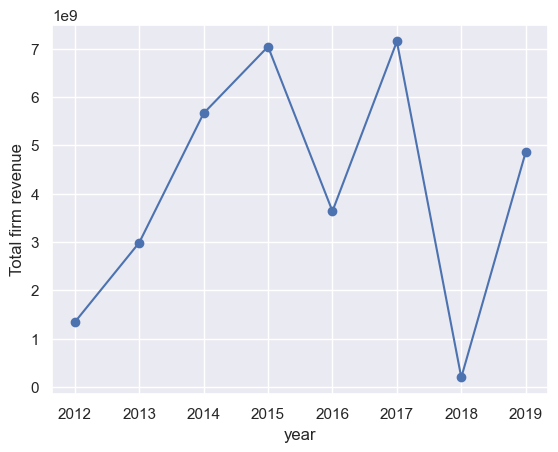

In [8]:
ax=dat.groupby('year').net_inc.sum().plot(marker='o'); 
ax.set_ylabel('Total firm revenue'); 

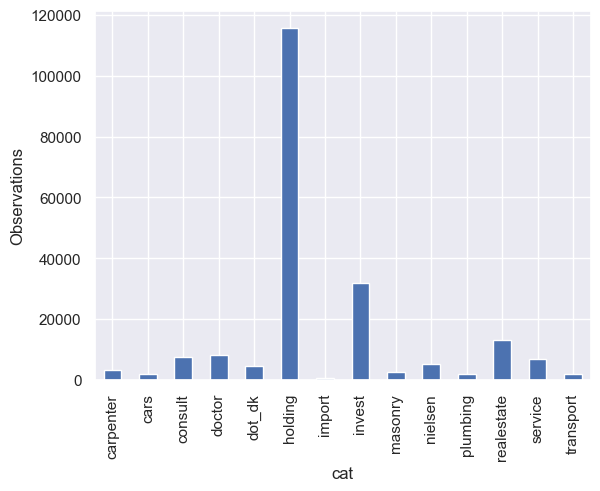

In [9]:
ax = dat.groupby('cat').taxable_income.count().plot(kind='bar'); 
ax.set_ylabel('Observations'); 

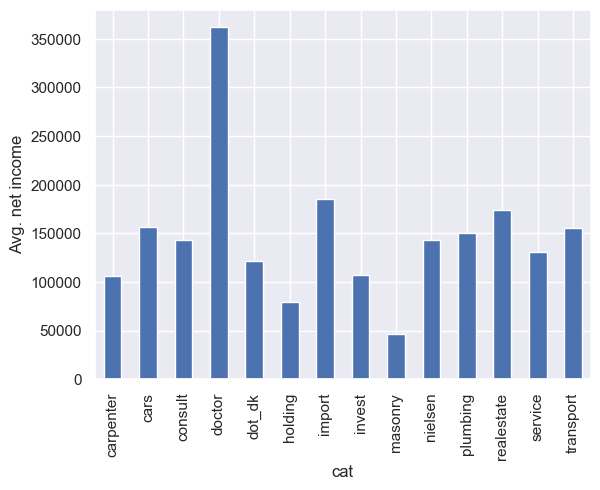

In [10]:
ax = dat.groupby('cat').taxable_income.mean().plot(kind='bar'); 
ax.set_ylabel('Avg. net income'); 

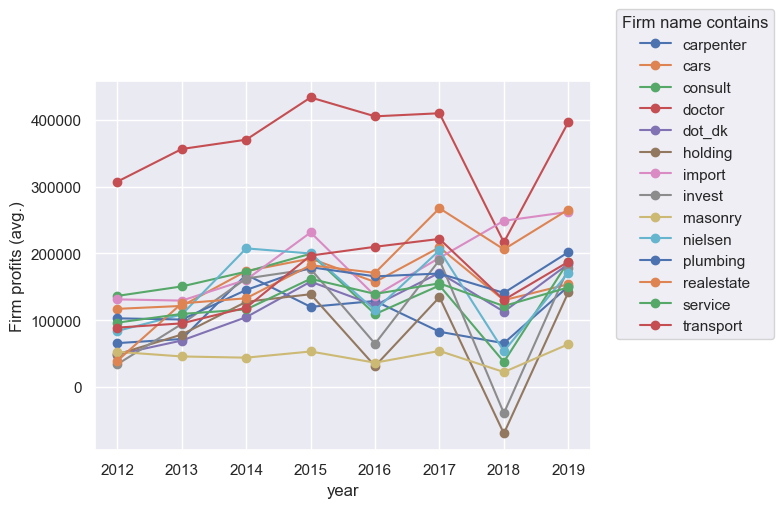

In [11]:
ax=dat.groupby(['year', 'cat']).taxable_income.mean().unstack().plot(marker='o'); 
ax.set_ylabel('Firm profits (avg.)'); 
ax.legend(title='Firm name contains', loc=(1.05,0.3)); 

# Set up data

In [12]:
# Select only firms that are in real estate in all years 
I = dat.groupby('firmid').dum_realestate.transform('all') # <-- creates an indicator for real estate
dat = dat[I].copy() # <-- pulls out real estate firms

In [13]:
# convenient list of the names of all the dummy variables
cols_dum = [c for c in dat.columns if c == 'dum_']

# convert int->bool 
for c in cols_dum: 
    dat[c] = dat[c].astype('bool')

N = dat.firmid.unique().size
T = dat.year.unique().size
print(f'Data has {dat.shape[0]:,d} rows: N = {N:,d}, T = {T}')

Data has 14,272 rows: N = 1,784, T = 8


In [14]:
# measure money in 1000 DKK 
for v in ['net_inc', 'taxable_income', 'deficit', 'tax']: 
    dat[v] = dat[v] / 1000.

In [15]:
# lag net income using "shift" from pandas
dat['lag_net_inc'] = dat.groupby('firmid').net_inc.shift(1)

### Pandas to numpy 

In [16]:
# remove nans due to differencing
I = dat.lag_net_inc.notnull() # cannot use first year: no lagged variable 

T = dat[I].year.unique().size # NB this measure of T already has one year subtracted 
N = dat[I].firmid.unique().size

assert dat[I].shape[0] == N*T, 'Data is not a balanced panel'

In [17]:
# turn panda data frames into numpy arrays
y = dat[I].net_inc.values.reshape((-1,1))
y_l = dat[I].lag_net_inc.values.reshape((-1,1))
const = np.ones((N*T,1))
x = np.column_stack((const, y_l))

#labels
ylbl = 'profit'
xlbl = ['const', 'lagged profit']

# Part 1: POLS
Today we will focus on a parsimonious model of profit $\pi$ (econometricians often use "parsimonious" to mean a "simple"). 

Consider first the following AR(1) (autoregressive model of order $1$),

$$
\pi_{it} = \alpha_0 +  \rho \pi_{it-1} + c_i + u_{it}, \quad t = 1, 2, \dotsc, T \tag{1}
$$

As we have seen before, if one does not take into consideration $c_i$ when estimating $\rho$, one will get biased results. One way to solve this, which is also a common way for AR(1) processes, is to take first-differences. We then have the model,

$$
\Delta \pi_{it} = \rho \Delta \pi_{it-1} + \Delta u_{it}, \quad t = 2, \dotsc, T \tag{2}
$$

This solves the presence of fixed effects.

### Question 1.1
Estimate eq. (1) using POLS and robust standard errors (you'll need to adjust the `robust` function in `LinearDynamic_ante.py` first.)
* Are there signs of autocorrelation in profit?
* What assumptions are no longer satisfied? What happens with fixed effects when we include a lag?

*Note:* We need to use the lagged values of net income. But this time we don't need to lag it ourselves as it that has already been done above.

$$
\pi_{it} = \alpha_0 +  \rho \pi_{it-1} + c_i + u_{it}, \quad t = 1, 2, \dotsc, T \tag{1}
$$

$$
\Delta \pi_{it} = \rho \Delta \pi_{it-1} + \Delta u_{it}, \quad t = 2, \dotsc, T \tag{2}
$$


$$
e_{it} = \Delta u_{it}
$$

$$
\hat{e}_{it}=\rho\hat{e}_{it-1}+error_{it},\quad t=\color{red}{3},\dotsc,T,\quad i=1,\dotsc,N
$$

In [30]:
years_org = dat.year.values.reshape(-1,1)
np.unique(years_org).size

8

In [33]:
years = dat[I].year.values.reshape(-1,1)
np.unique(years).size

7

In [22]:
T

7

In [18]:
def fd_matrix(T):
    D_T = -np.eye(T)+np.eye(T,k=1) # Fill in
    D_T = D_T[:-1]
    return D_T

D_T = fd_matrix(T)

In [24]:
D_T

array([[-1.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  1.]])

In [40]:
y_diff = lm.perm(D_T, y)
y_diff_l = lm.perm(D_T,y_l)

In [43]:
serr_corr = lm.serial_corr(y=y_diff, x=y_diff_l, T=T, year=years)

lm.print_table(results=serr_corr, labels=(ylbl, ['$e_{it-1}$']))

Results
Dependent variable: profit

                  Beta         Se    t-values
----------  ----------  ---------  ----------
$e_{it-1}$  -0.0977338  0.0109602    -8.91716
R² = 0.007
σ² = 555080.779


It would seem there is autocorrelation/serial correlation. 

In [48]:
# FILL IN
# Estimate the AR(1) model using OLS and robust standard errors
# Print out in a nice table

ar1_result = lm.estimate(y=y, x=x, T=T, robust_se=True)
lm.print_table(results=ar1_result, labels=(ylbl, xlbl))

Results
Dependent variable: profit

                   Beta         Se    t-values
-------------  --------  ---------  ----------
const          73.4937   7.77624       9.45105
lagged profit   0.51742  0.0347261    14.9
R² = 0.252
σ² = 476937.886


Your table should look like this:


AR(1)
Dependent variable: profit

|              |  Beta |     Se|   t-values | 
|------------- | ------|  -------|  ----------|
|const   |       73.494 | 7.77624 |      9.45|
|lagged profit |  0.517 | 0.03473  |     14.90| 
R² = 0.252
σ² = 476937.886

In [49]:
# in case you want results in a panda data frame
ar1_res=pd.DataFrame([ar1_result['b_hat'].flatten(), ar1_result['se'].flatten(),ar1_result['t_values'].flatten()], 
             index=['beta', 'se', 't'], columns=xlbl).T
ar1_res.round(2)


,beta,se,t
const,73.49,7.78,9.45
lagged profit,0.52,0.03,14.90


In [50]:
# or as a latex table
(ar1_res.round(2)).style.to_latex()

'\\begin{tabular}{lrrr}\n & beta & se & t \\\\\nconst & 73.490000 & 7.780000 & 9.450000 \\\\\nlagged profit & 0.520000 & 0.030000 & 14.900000 \\\\\n\\end{tabular}\n'

### Question 1.2
Estimate eq. (2) using first differences. 
* What problem does this solve? 
    - Fixed effects (inherent time-invariant that may raise profits)
* What type of exogeneity assumption is used to justify this method of estimation?
    - Strict exogeneity. 
    
    $E\left(u_{i t} \mid \mathbf{x}_{i t+1}, \mathbf{x}_{i t}, \mathbf{x}_{i t-1}\right)=0$

    OR
    
    $E[\Delta \pi_{t} \Delta \pi_{t-1}]=0$
    

*Note 1:* You have to create the first differencing matrix yourself, and use the `perm` function to permutate the dependen and independent variables. <br>
*Note 2:* This time you should use robust standard errors. The function is provided to you.

In [62]:
# FILL IN
# Create a first difference matrix
F_T = fd_matrix(T)

# First difference both profit and lag of profit
y_fd = lm.perm(F_T, y)
y_fd_l = lm.perm(F_T, y_l)

# Estimate AR(1) model using OLS with robust se and print a nice table

ar1_diff = lm.estimate(y=y_fd, x=y_fd_l, robust_se=True, T=T-1, transform='fd')
lm.print_table(results=ar1_diff, labels=(ylbl, [xlbl[1]]))


Results
Dependent variable: profit

                    Beta         Se    t-values
-------------  ---------  ---------  ----------
lagged profit  -0.412494  0.0244187    -16.8926
R² = 0.167
σ² = 520184.128


Your table should look like this:

FD AR(1) <br>
Dependent variable: profit

|              |   Beta |     Se |   t-values |
|------------- | ------ | ------ | ---------- |
|lagged profit | -0.412 | 0.0244 |     -16.89 |
R² = 0.167
σ² = 520184.128

## Super short introduction to pooled IV (piv)

Suppose we want to estimate the effect of $x_K$ on $y$, conditional on $K - 1$ other controls, we then have the usual equation,

$$
\mathbf{y} = \mathbf{X} \boldsymbol{\beta} + \mathbf{u} \tag{3}
$$

where $\mathbf{X} = (\mathbf{x}_1, \dotsc, \mathbf{x}_K)$. If $\mathbf{x}_K$ is not exogenous, we can define the instrument vector $\mathbf{Z} = (\mathbf{x}_1, \dotsc, \mathbf{x}_{K - 1}, \mathbf{z}_1)$, where $\mathbf{z}_1$ is an instrument for $\mathbf{x}_K$. The details and necessary assumptions and conditions are outlined in Wooldridge (2010) (chapter 5).

We can estimate eq. (3) by OLS using $z_1$ as an instrument for $x_K$, in order to make it easier for you when writing code, I write it up in matrix notation,

$$
\boldsymbol{\hat{\beta}} = (\mathbf{\hat{X'}}\mathbf{\hat{X}})^{-1} \mathbf{\hat{X'}}\mathbf{Y}, \tag{4}
$$

where $\mathbf{\hat{X}} = \mathbf{Z}(\mathbf{Z'}\mathbf{Z})^{-1}\mathbf{Z'}\mathbf{X}$.

# Part 2: Pooled IV
It should not be a surprise that models (1) and (2) violate the strict exegoneity assumption but even if we relax this assumption to sequential exegoneity, the FD-estimator remains inconsistent.

A solution to this is to use an instrument for $\Delta \pi_{it-1}$. The biggest issue is to find an instrument that is not only relevant, but also exogenous.

We often use an additional lag as instruments. So for $\Delta \pi_{it-1}$, we can use $\pi_{it-2}$. In general, we have all possible lags available as instruments. So for $\Delta \pi_{it-1}$ we have, $
\pi_{it-2}^{\textbf{o}} = (\pi_{i0}, \pi_{i1}, \dotsc \pi_{it-2})$ available as instruments.

*Note:* $R^2$ has no meaning in IV-regressions, you can report it if you want to. But I set it to 0.

### Question 2.1
Estimate eq. (2) by using the lag of the independent variable in levels, $z_{it} = \pi_{it-2}$ as an instrument. You need to finish writing the `est_piv` function and a part of the `estimate` function in `LinearDynamic_ante`.

*Note 1:* In the `estimate` function, the `variance` function takes $\mathbf{X}$ as an argument. But we want to pass the `variance` function $\mathbf{\hat{X}}$ instead. <br>
*Note 2:* In order to create the instrument, you need to create a lag matrix, and use `perm`.

$$
\pi_{it} = \alpha_0 +  \rho \pi_{it-1} + c_i + u_{it}, \quad t = 1, 2, \dotsc, T \tag{1}
$$

$$
\Delta \pi_{it} = \rho \Delta \pi_{it-1} + \Delta u_{it}, \quad t = 2, \dotsc, T \tag{2}
$$


$$
e_{it} = \Delta u_{it}
$$

$$
\hat{e}_{it}=\rho\hat{e}_{it-1}+error_{it},\quad t=\color{red}{3},\dotsc,T,\quad i=1,\dotsc,N
$$

In [81]:
# FILL IN
# Create first a lag matrix
def lag(T):
    L_T = np.eye(T, k=-1)
    return L_T[1:]

L_T = lag(T)

# Lag the lagged pi variable

y_diff = lm.perm(D_T, y)        #\Delta \pi_t
y_diff_l = lm.perm(D_T,y_l)     #\Delta \pi_t-1

y_2_lag = lm.perm(L_T, y_l)     #\pi_t-2

z = y_2_lag

# Finish writing the est_piv function in lineardynamic_ante
# Finish writing the estimate function in lineardynamic_ante
# Estimate using first differences and lagged first differences. Use the 2. lag as instrument.

In [98]:
FD_IV_AR1 = lm.estimate(y=y_diff, x=y_diff_l, z=z, robust_se=True, T=T-1)
lm.print_table(results=FD_IV_AR1, labels=(ylbl, [xlbl[1]]))

Results
Dependent variable: profit

                   Beta         Se    t-values
-------------  --------  ---------  ----------
lagged profit  0.129112  0.0763243     1.69163
R² = nan
σ² = 700805.974


Your table should look like this:

FD-IV AR(1) <br>
Dependent variable: delta profit

|                   |   Beta |     Se |   t-values |
|-------------------|--------|--------|------------|
| lagged profit     |  0.129 |  0.0763|      1.69 | 
R² = n.a. <br>
σ² = 700805.974

### Question 2.2
Estimate eq. (2) by using the lag of the independent variable in first differences, $z_{it} = \Delta \pi_{it-2}$ as an instrument.

In [ ]:
# FILL IN
# Lag the first differenced lag profit variable
# The second lag uses up an extra observation, so you need to shorten both first differenced profit and the 1. first difference lag.
# Estimate using first differences and lagged first differences. Use the 2. first difference lag as instrument.

In [100]:
#  do lagging and differencing by panda data frames (instead of perm function)
dat['diff_net_inc']      = dat.groupby('firmid').net_inc.diff()
dat['lag_diff_net_inc']  = dat.groupby('firmid').diff_net_inc.shift(1)
dat['lag2_diff_net_inc'] = dat.groupby('firmid').diff_net_inc.shift(2)

In [101]:
# load into numpy
I = dat.lag2_diff_net_inc.notnull() # removes years which have become zeros due to differencing
yfd    = dat[I].diff_net_inc.values.reshape((-1,1))
yfd_l1 = dat[I].lag_diff_net_inc.values.reshape((-1,1))
yfd_l2 = dat[I].lag2_diff_net_inc.values.reshape((-1,1))

assert (dat.groupby('firmid').year.size() == dat.year.unique().size).all(), 'not balanced'

In [105]:
# Estimate using lagged difference as IV and data generated by perm function
x_label= ['lag \Delta profit'] # fill in
AR_fdiv2_res2 = lm.estimate(y=yfd, x=yfd_l1, z=yfd_l2, robust_se=True, T=T-2) # Fill in
lm.print_table((ylbl,x_label), AR_fdiv2_res2,title='FD-IV AR(1)')

FD-IV AR(1)
Dependent variable: profit

                         Beta        Se    t-values
-----------------  ----------  --------  ----------
lag \Delta profit  -0.0321733  0.137085   -0.234697
R² = nan
σ² = 659600.152


Your table should look like this:
FD-IV AR(1) <br>
Dependent variable: delta profit

|                   |   Beta |     Se |   t-values |
|-------------------|--------|--------|------------|
| lag delta profit|  -0.032 | 0.1317 |       -0.23 |
R² = NaN <br>
σ² = 659600.152

### Summing up Exercises 1 and 2.

First of all, is it more convincing to use $\pi_{it-2}$ or $\Delta \pi_{it-2}$ as an instrument for $\Delta \pi_{it-1}$?

Then consider how the different models compare to each other. Some questions that you might discuss with your class mates could be:
* Which ones do you feel gives most sense from an economic perspective?
* Which ones gives most sense from an econometric perspective? 
* Do you feel that there is conclusive evidence that there is state dependence in profit?
* Should we give financial aid packages to this industry when  exogenous shocks hit (e.g. Covid)?

---

Let's backtrack a little.

Define dynamic panel data model:

$$
y_{i t}=c_i+\rho y_{i t-1}+\boldsymbol{x}_{i \boldsymbol{t}} \boldsymbol{\beta}+u_{i t}
$$

POLS is inconsistent, as $E[c_i\boldsymbol{x}_{i \boldsymbol{t}}]\neq 0$. Bad.

*What about FE/FD?*

They require strict exogeneity.

AR(1)-FD model (ignoring potential covariates $x$):

$$
\Delta \pi_{i t}=\rho \Delta \pi_{i t-1}+\Delta u_{i t}
$$

Is $E[\Delta \pi_{i t-1}\Delta u_{i t}] = 0$?

**No.** Why?

\begin{align*}
    \Delta \pi_{i t}&=\rho \Delta \pi_{i t-1}+\Delta u_{i t} \\
                    (\pi_{i t}-\pi_{i t-1})&=\rho (\pi_{i t-1}-\pi_{i t-2})+(u_{i t}-u_{i t-1})
\end{align*}

Enough to see, that $-E[\pi_{t-1}u_{t-1}]\neq 0 $. **INCONSISTENT**

---

Solution: Instrument $\Delta \pi_{t-1}$ with an instrument $z_{it}$:

We require:

1) Exogeneity: $\quad E\left(\mathbf{z}_{i t} \Delta u_{i t}\right)=0$

2) Relevance: $\quad E\left(\mathbf{z}_{i t} \Delta \pi_{t-1}\right) \neq 0$

*But which instrument?*

---

Let's say there's an exogenous corona shock at time $t-1$. 

$\color{cyan}{\pi_{t-2}}$ as instrument for $\Delta \pi_{t-1}$?

1) Exogeneity:
    
    - $E[\pi_{t-2} \Delta u_{it}]=E[\pi_{t-2} (u_{it}-u_{it-1})]=0$?
    - *Yes*, profits at time $t-2$ is not correlated with the corona shock at $t-1$.

2) Relevance:
    
    - $E[\pi_{t-2} \Delta \pi_{t-1}]=E[\pi_{t-2} (\pi_{t-1}-\pi_{t-2})] \neq 0?$
    - *Yes*, profits  at time $t=2$ is most certainly correlated with the difference in profits from period $t-2$ to $t-1$.

$\color{cyan}{\Delta \pi_{t-2}}$ as instrument for $\Delta \pi_{t-1}$?

1) Exogeneity: 

    - $E[\Delta \pi_{t-2} \Delta u_{it}]=E[(\pi_{t-2}-\pi_{t-1}) (u_{it}-u_{it-1})]=0$?
    - *No*, enough to see that $-E[\pi_{t-1}u_{t-1}]\neq 0 $. Profits at time $t-1$ are of course correlated with an exogenous corona shock at time $t-1$.

2) Relevance:

    - $E[\Delta \pi_{t-2} \Delta \pi_{t-1}]=E[(\pi_{t-2}-\pi_{t-1})(\pi_{t-1}-\pi_{t-2})] \neq 0?$
    - *Yes*, enough to see that $-E[\pi_{t-1}u_{t-1}]\neq 0 $. While it is a relevant instrument, it is violating the exogeneity assumption (see above).

---

Instrumenting $\Delta \pi_{t-1}$ with $\color{cyan}{\pi_{t-2}}$, we found that:

FD-IV AR(1) <br>
Dependent variable: delta profit

|                   |   Beta |     Se |   t-values |
|-------------------|--------|--------|------------|
| lagged profit     |  0.129 |  0.0763|      1.69 | 
R² = n.a. <br>
σ² = 700805.974

We reject the notion of state dependence. That is, previous (potentially poor) profits does not have persistent effect on future firm performance. This does not support the idea of giving support to firms in the event exogenous shock (such as COVID-19).

---

## Part 3: GMM

### Question 3.1: Create the level instrument matrix $\mathbf{Z^{\mathbf{o}}}$

The function `sequential_instruments` in `gmm.py` in creates the instrument matrix $\mathbf{Z^{\mathbf{o}}}$ using the second lag of $\pi$ in **levels**. Note that you will not have one array that looks like $\mathbf{Z^{\mathbf{o}}}$, but an array that has something that looks like $\mathbf{Z^{\mathbf{o}}}$ for each firm in the data. Since we have six time periods, and access to $y_{i0}$, you should get five rows of instruments for each firm.
$$
\mathbf{Z^{\mathbf{o}}} = 
\begin{bmatrix}
    y_{i0} & 0 & 0 & 0 & 0 & 0 & \cdots & 0 \\
    0 & y_{i0} & y_{i1} & 0 & 0 & 0 & \cdots & 0 \\
    0 & 0 & 0 & y_{i0} & y_{i1} & y_{i2} & \cdots & 0 \\
    \vdots  & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
    0 & 0 & 0 & 0 & 0 & 0 & \cdots & \mathbf{y^o_{it-2}} \\
\end{bmatrix}
\begin{pmatrix}
t = 2 \\
t = 3 \\
t = 3 \\
\vdots \\
t = T
\end{pmatrix}.
$$

In [107]:
import gmm_ante as gmm

In [108]:
# reset: now we no longer need to delete *3* years but only 2. This is because we're letting the IV matrix expand over time.
I = dat.lag_diff_net_inc.notnull()

yfd    = dat[I].diff_net_inc.values.reshape((-1,1))
yfd_l  = dat[I].lag_diff_net_inc.values.reshape((-1,1))
years  = dat[I].year.values

In [109]:
# Create (telescoping) instrument matrix 
z = gmm.sequential_instruments(y_2_lag, T)
print(z)

[[-28.187   0.      0.    ...   0.      0.      0.   ]
 [  0.    -28.187 -62.855 ...   0.      0.      0.   ]
 [  0.      0.      0.    ...   0.      0.      0.   ]
 ...
 [  0.      0.      0.    ...   0.      0.      0.   ]
 [  0.      0.      0.    ...   0.      0.      0.   ]
 [  0.      0.      0.    ... 690.033 511.393 585.533]]


##### your instrument matrix should look like this:
$$
\begin{bmatrix}
-28.187 &  0. &     0.  &  ... &  0.  &    0.  &    0.   \\
 0.  &  -28.187 & -62.855& ... &  0.   &   0.  &    0.   \\
  0. &     0.  &    0. &   ... &  0.  &    0.  &    0.   \\
 &&&...&&&\\
   0.   &   0.   &   0. &   ... &  0.  &    0.  &    0.   \\
   0.    &  0.  &    0.  &  ...  & 0.    &  0.   &   0.   \\
   0.  &    0.   &   0.  &  ... & 690.033 & 511.393 &585.533\\
 \end{bmatrix}
 $$

### Question 3.2: GMM 1-step and 2-step

Compute the following quantities: 

a) the initial weighting matrix, 

b) the first-step gmm estimator, 

c) the updated weighting matrix, 

d) the 2-step gmm estimator,

e) the standard errors,

f) the Sargent statistic

*Note: In formulas below we do not include $\frac1N$ in  the definition of $\hat{\mathbf{W}}$. This only has implications for the formula for $\text{Avar}(\hat{\boldsymbol{\beta}})$.*

a) Write the initial weighting matrix $\hat{\mathbf{W}}$ used for the 1-step GMM estimator (equivalent to System 2SLS). What are $\hat{\mathbf{W}}$'s dimensions?

$$\mathbf{W}=(\mathbf{Z}'\mathbf{Z})^{-1}$$

In [112]:
# Compute the initial weighting matrix 
W=la.inv(z.T@z)


b) Compute the first step GMM estimator:

$$\hat{\boldsymbol{\beta}}_{GMM}= (\mathbf{X}'\mathbf{Z}\hat{\mathbf{W}}\mathbf{Z}'\mathbf{X})^{-1}\mathbf{X}'\mathbf{Z}\hat{\mathbf{W}}\mathbf{Z}'\mathbf{Y}$$

In [114]:
# Compute the 2sls estimator (1-step GMM)
beta_gmm=la.inv(y_fd_l.T@z@W@z.T@y_fd_l)@y_fd_l.T@z@W@z.T@y_fd
print("beta_gmm=",beta_gmm)

beta_gmm= [[-0.02163]]


you should get: `beta_gmm=[[-0.02163]]`

c) Write the expression for the updated weighting matrix used for 2-step GMM (Arellano Bond). What is the dimension of this matrix?


$$\hat{\mathbf{W}}^{\text{opt}}
= \left(\sum^N_{i=1}\mathbf{Z}_i'\hat{\mathbf{u}}_i\hat{\mathbf{u}}_i'\mathbf{Z}_i \right)^{-1}$$

In [115]:
z.shape

(10704, 21)

In [116]:
# Compute the updated weighting matrix
# you'll need to compute residuals ui_hat
# you should use a loop to multiply each individual's Z_i and ui_hat separately
res = y_fd-y_fd_l@beta_gmm

S=np.zeros((z.shape[1],z.shape[1]))
for i in range(N):
        idx = slice(i*(T-1), (i + 1)*(T-1)) # rows for individual i 
        zi = z[idx]
        resi = res[idx]
        S += zi.T@(resi@resi.T)@zi
W_opt=la.inv(S)

In [120]:
W_opt

array([[ 7.48147e-16,  3.67154e-16, -2.03557e-16,  1.91948e-16,
         1.61370e-16, -1.55514e-16,  1.80372e-16,  1.34800e-16,
        -1.69600e-16,  5.37212e-17,  1.37901e-17,  5.76005e-17,
         7.78854e-17, -3.70455e-17, -6.60175e-17, -9.77875e-17,
        -2.49994e-16,  3.44807e-16, -3.37041e-17,  3.12954e-17,
        -1.44593e-16],
       [ 3.67154e-16,  2.41508e-15, -1.47188e-15,  1.27232e-15,
        -5.86573e-16,  5.07875e-17,  9.94694e-16, -5.21464e-16,
        -8.65491e-17,  2.63461e-16,  7.20011e-16, -3.80058e-16,
         2.90286e-16, -1.58448e-16,  9.69818e-18, -2.31766e-16,
         4.53936e-16, -3.59347e-16,  2.63587e-16,  7.14509e-17,
        -2.78567e-17],
       [-2.03557e-16, -1.47188e-15,  1.37215e-15, -7.65331e-16,
         5.46910e-16, -9.79207e-17, -6.00196e-16,  3.73850e-16,
         1.77152e-16, -2.05139e-16, -3.85849e-16,  2.37952e-16,
         2.41788e-18, -7.46593e-17, -1.59001e-17,  3.56430e-16,
        -3.57635e-16,  4.05643e-16, -2.91815e-16,  2.48788

d) Compute the second-step GMM estimator using this weighting matrix

$$\hat{\boldsymbol{\beta}}_{GMM}^{\text{opt}}= (\mathbf{X}'\mathbf{Z}\hat{\mathbf{W}}^{\text{opt}}\mathbf{Z}'\mathbf{X})^{-1}\mathbf{X}'\mathbf{Z}\hat{\mathbf{W}}^{\text{opt}}\mathbf{Z}'\mathbf{Y}$$

In [121]:
# Compute the 2-step GMM estimator 
beta_gmm2 = la.inv(y_fd_l.T@z@W_opt@z.T@y_fd_l)@y_fd_l.T@z@W_opt@z.T@y_fd
print("beta_gmm=",beta_gmm2)

beta_gmm= [[0.07076]]


You should get: `beta_gmm= [[0.07076]]`

e) Compute standard errors: 
$$\hat{\mathbf{V}}(\hat{\boldsymbol{\beta}}_{\text{GMM}}^{\text{opt}}) = \left(\mathbf{X'}\mathbf{Z}\hat{\mathbf{W}}^{\text{opt}}\mathbf{Z}'\mathbf{X}\right)^{-1}$$

In [125]:
X = yfd_l
Z = z
W = W_opt
cov = la.inv(X.T@Z@W@Z.T@X)
se = np.sqrt(cov)
print(f'se = {se}, t = {beta_gmm2/se}')

se = [[0.03733]], t = [[1.8954]]


You should get: `se = [0.03733], t = [[1.8954]]`

f) Write up the Sargan Test Statistic. What does it provide a test of? What can you conclude from this test?

$$
\mathbf{J}:=\hat{\mathbf{u}}^{\prime} \mathbf{Z} \mathbf{W} \mathbf{Z}^{\prime} \hat{\mathbf{u}} \sim \chi_M^2
$$

where $\mathbf{W} = (N \hat{\mathbf{S}})^{-1}= (\sum_i \mathbf{Z}_i' \hat{\mathbf{u}}_i\hat{\mathbf{u}}_i' \mathbf{Z}_i)^{-1}$

In [126]:
#Compute the Sargan Test Stat
J = res.T@Z@W@Z.T@res

# Run test and print results
r=z.shape[1] # number of instruments
K=yfd_l.shape[1] # number of regressors
df=r-K # number of overidentifying restrictions
p_val = chi2.sf(J.flatten()[0], df)

print(f'The Sargan test statistic is: {J.item():.2g}, with p-value: {p_val:.2g}.')

The Sargan test statistic is: 43, with p-value: 0.002.


The Sargent test tells us if there is overidentifying restrictions.

Under the null, all IV's are all valid.

We reject the null and conclude that *at least* one instrument is invalid.

You should get

The Sargan test statistic is: 43, with p-value: 0.002.